# Steady-state analysis



In [1]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)


## Set up the environment

RESET


<IPython.core.display.Javascript object>


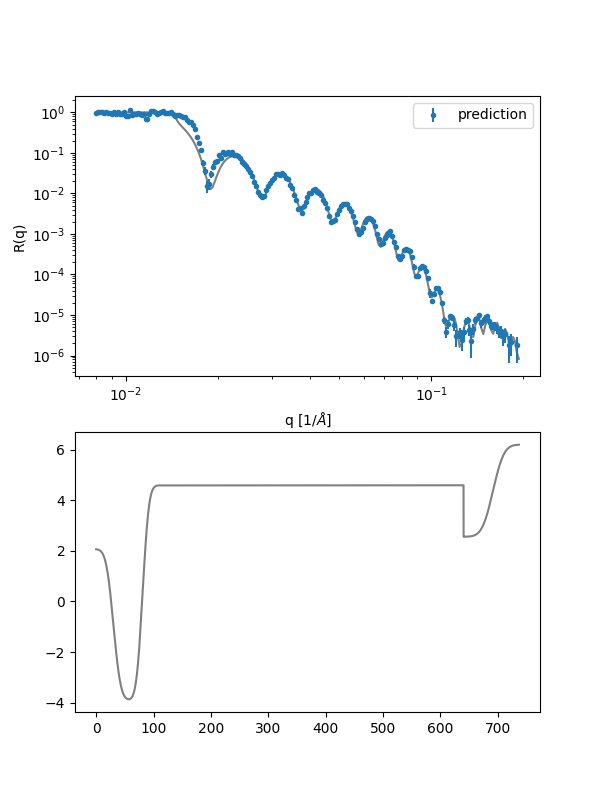

In [143]:
import steady_state
importlib.reload(steady_state)

# OCV 1
data_file = os.path.join(git_dir, 'data', 'REFL_207268_combined_data_auto.txt')

# OCV 2
data_file = os.path.join(git_dir, 'data', 'REFL_207282_combined_data_auto.txt')

RUN = 206938
data_file = os.path.join(git_dir, 'data', 'REFL_%d_combined_data_auto.txt' % RUN)

_data = np.loadtxt(data_file).T
_data[1] = _data[1]/1.06

# Initial state is entered as a list of layers.
# First layer is the incoming medium.
# Layer parameter [0:thickness, 1:interface, 2:rho, 3:irho]

initial_state = [[0, 15, 6.2, 0],
                 [50, 10, 3, 0],
                 [550, 10, 6.7, 0],
                 [50, 10, -2, 0],
                 [0, 0, 2.07, 0]
                ]


# create an instance of our custom environment
env = steady_state.AnalyzerEnv(initial_state=initial_state,
                               data=_data, engine='amoeba')

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
print("RESET")
env.reset()
env.plot(errors=True)


## View the initial time and check that the initial model makes sense

ACTION
BEFORE:

Current parameters:
Layer 0: 0	15	6.2	0
Layer 1: 45.1739	16.3803	2.00093	0
Layer 2: 559.76	8.89404	5.56365	0
Layer 3: 51.9327	11.4743	-1.87587	0
Layer 4: 0	0	2.07	0

52.4844535 45.173898339271545
[0.05248445 0.11293475 0.6        0.        ]
52.4844535 45.173898339271545 0.11293474584817886
 - Inserting layer at index 1 with parameters 0.06189168=[0.05248445 0.11293475 0.6        0.        ]

Current parameters:
Layer 0: 0	15	6.2	0
Layer 1: 52.4845	22.5869	4	0
Layer 2: 45.1739	16.3803	2.00093	0
Layer 3: 559.76	8.89404	5.56365	0
Layer 4: 51.9327	11.4743	-1.87587	0
Layer 5: 0	0	2.07	0

reward: -22.43065059398674
chi2: 22.4307
[0.9532451  0.1        0.06189168 0.05248445]


<IPython.core.display.Javascript object>


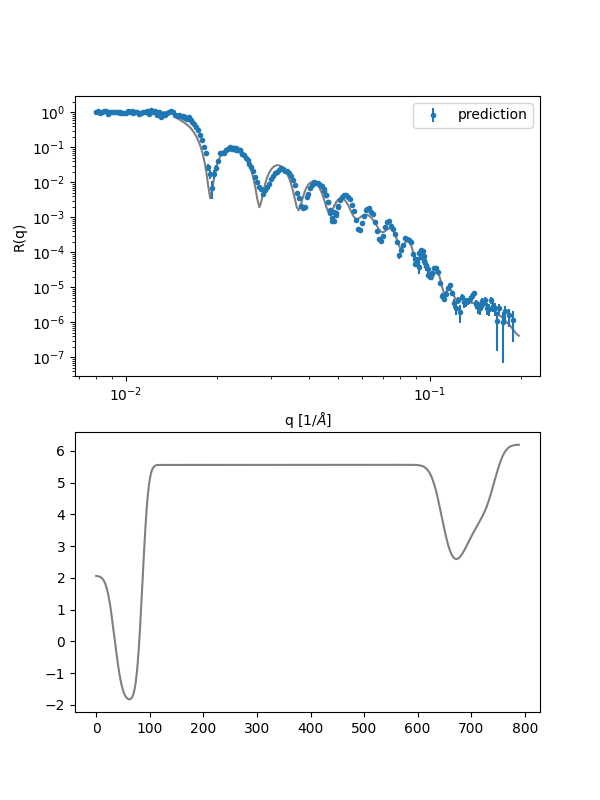

In [112]:
# choose a random action or use our initial fit
env.reset()
action = env.action_space.sample()

# Inserting layers
action = np.asarray([0.9532451,  .10, 0.06189168,  0.0524844535])

# Changing layer param
#action = np.asarray([0.5,  .5, 0.4,  0.24844535])

# Deleting layer
#action = np.asarray([0.,  0., 0,  0.24844535])

print("ACTION")
env.engine = None

# take the action and get the information from the environment
new_state, reward, terminated, truncated, info = env.step(action, True)
#new_state, reward, terminated, truncated, info = env.step(action)
#new_state, reward, terminated, truncated, info = env.step(action)
#new_state, reward, terminated, truncated, info = env.step(action)
print("reward: %s" % reward)
print("chi2: %g" % env.chi2)

# show the current position and reward
env.render(action=action, reward=reward) 


env.plot(errors=True)

## Train or load model

In [144]:
%%time

from stable_baselines3 import PPO, SAC, A2C
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(
    save_freq=1000,
    save_path="./logs-%s/" % RUN,
    name_prefix="steady-state",
    save_replay_buffer=False,
    save_vecnormalize=True,
)

model = SAC('MlpPolicy', env, use_sde=False, verbose=0)  #, device='cuda')

if True:
    model.learn(12000)
    #model.learn(80000, callback=checkpoint_callback)
    model.save('steady-state-%s' % RUN)
else:
    model = SAC.load('steady-state-%s' % RUN)

CPU times: user 1h 4min 36s, sys: 2min 33s, total: 1h 7min 10s
Wall time: 1h 5min 7s


## Run the agent on the time series data

Starting chi2: 5.91287
0: -2.78359 2.78359 0.6 [False]

1: -1.78111 1.68111 0.7 [False]



<IPython.core.display.Javascript object>


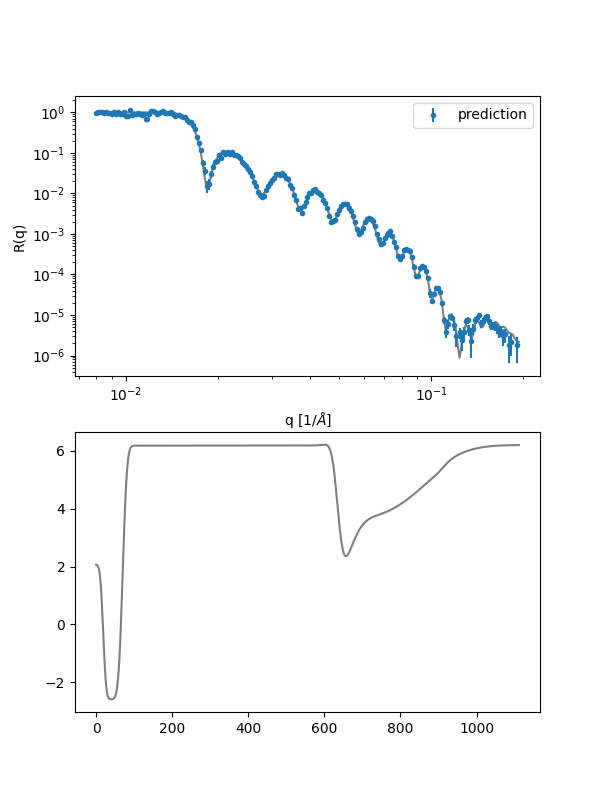

In [147]:
# Evaluate the agent

obs, info = env.reset()
env.reward_cutoff = 1.3
env.engine = 'amoeba'
#env.engine = 'dream'
print("Starting chi2: %g" % env.chi2_0)
chi2 = []
for i in range(2):
    action, _ = model.predict(obs, deterministic=True)
    #print(action)
    chi2.append(env.chi2)
    new_obs, reward, terminated, truncated, info = env.step(action, False)  
    print("%d: %g %g %g [%s]\n" % (i, reward, env.chi2, env.state[0], terminated))
    if truncated:
        env.reset()
    else:
        obs = new_obs

    if terminated:
        break



env.plot(errors=True)

# Compute uncertainties

In [117]:
"""
  Show an uncertainty band for an SLD profile.
  This currently works for inverted geometry and fixed substrate roughness, as it aligns
  the profiles to that point before doing the statistics.
"""
from refl1d import errors
import numpy as np


def get_sld_contour(problem, state, cl=90, npoints=1000, trim=1000, portion=.3, index=1, align='auto'):
    points, _logp = state.sample(portion=portion)
    #points = points[-trim:-1]
    points = points[:trim]
    original = problem.getp()
    _profiles, slabs, Q, residuals = errors.calc_errors(problem, points)
    problem.setp(original)
    
    profiles = errors.align_profiles(_profiles, slabs, align)

    # Group 1 is rho
    # Group 2 is irho
    # Group 3 is rhoM
    contours = []
    for model, group in profiles.items():
        ## Find limits of all profiles
        z = np.hstack([line[0] for line in group])
        zp = np.linspace(np.min(z), np.max(z), npoints)

        # Columns are z, best, low, high
        data, cols = errors._build_profile_matrix(group, index, zp, [cl])
        contours.append(data)
    return contours

# steps: 7, # draws: 2100


<IPython.core.display.Javascript object>


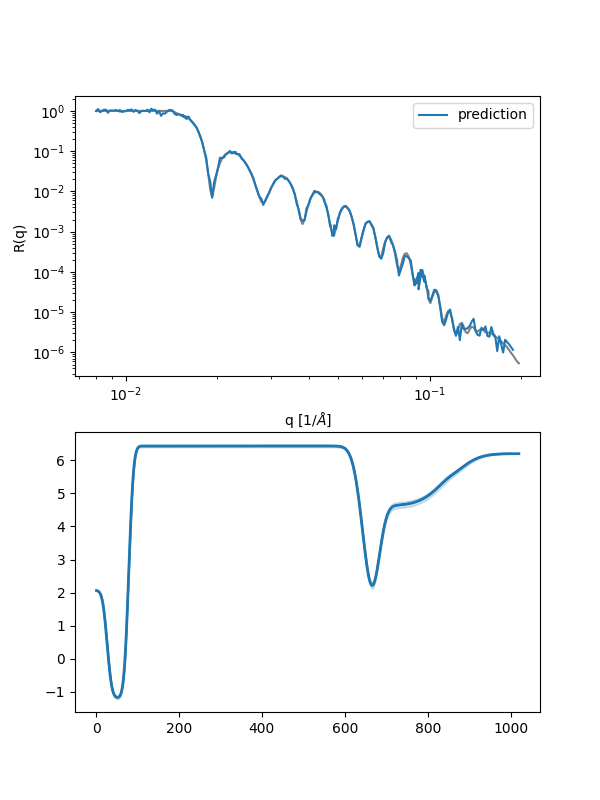

In [122]:
from bumps.fitters import fit
results = fit(env.problem, method='dream', samples=2000, burn=2000, pop=20, verbose=None)
env.plot()

z, best, low, high = get_sld_contour(env.problem, results.state, cl=95, align=-1)[0]

# Find the starting point of the distribution
for i in range(len(best)-1, 0, -1):
    if np.fabs(best[i] - best[i-1]) > 0.001:
        break

_z = z[i]-z+0
plt.plot(_z[:i], best[:i], markersize=4, label='', linewidth=2,)
plt.fill_between(_z[:i], low[:i], high[:i], alpha=0.2, color=plt.gca().lines[-1].get_color())

## Plot the results and compare to the Bayesian approach

In [16]:
print(env.results.state)

# Training progression

<IPython.core.display.Javascript object>


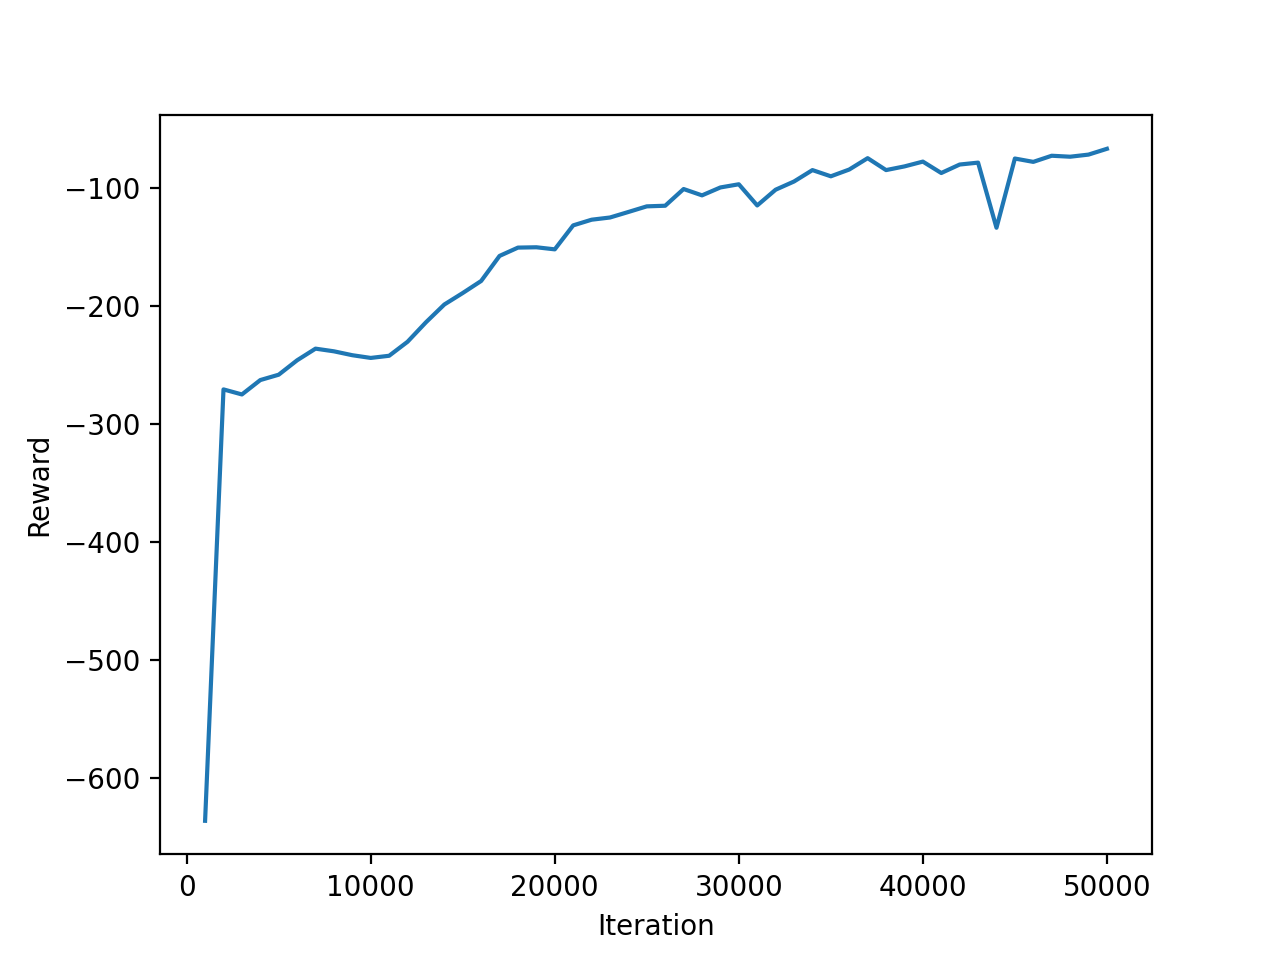

In [10]:
log_dir = "./logs-forward-no-final-state/"
log_dir = "./logs-06-to-01-fwd/"
_dir_list = os.listdir(log_dir)

def evaluate(model):
    episode_reward = 0
    n_times = len(env.data)
    obs, info = env.reset()

    chi2 = 0
    for i in range(n_times):
        action, _ = model.predict(obs, deterministic=True)
        chi2 += env.chi2
        obs, reward, terminated, truncated, info = env.step(action)  
        episode_reward += reward
    return episode_reward

itr_list = []
reward_list = []

for file in _dir_list:
    model = SAC.load(os.path.join(log_dir, file))
    reward = evaluate(model)
    iteration = int(file.replace("rl_model-forward_", "").replace("_steps.zip", ""))
    itr_list.append(iteration)
    reward_list.append(reward)

itr_list = np.asarray(itr_list)
reward_list = np.asarray(reward_list)
idx = itr_list.argsort()

fig = plt.figure(dpi=100)
plt.plot(itr_list[idx], reward_list[idx])
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.show()
        